Tech stages
- First version from other team members sees solar wind speed peak, then sends warning, which we get before it hits
- Second version to increase warning time by predicting peak in advance

Conventional procedure
- Get data
- Create model, from full data, for 1 threshold speed
- Predict (probability or catagorise, over/under threshold speed) from new data point
- Evaluate prediction
    - Split data via k-fold
    - For each split
        - Create model from training data
        - Predict from test data
        - Score (accuracy/precision/recall/F1-score at one probability threshold, or ROC curve area for all)
    - Average scores

Input DataFrame columns
- 'Solar wind speed at rise start' 
- 'Speed 1 hour after start'
- 'Speed at peak'

Series comparison error types
- Boolean / binary / categorical
    - Accuracy
    - Precision
    - Recall
    - F1-score
    - Balanced accuracy score 
        - https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score
        - https://en.wikipedia.org/wiki/F-score#Diagnostic_testing
- Numerical / regression
    - Single values
        - Mean error
        - MAE
        - RMSE
    - Values with uncertainties
        - Agreement rate / accuracy
    - Distributions
        - Skill score

Tasks
- Questions
    - What is the equivalent of F1-score for numerical series? Doesn't accuracy lead to same problems as with Boolean? Is it based on over/underestimates instead?
- Create and evaluate linear regression based model
    - Generate random practice data
    - Get actual data
    - Practice model
        - Create single model, from full data, with single arbitrary threshold speed
        - Prediction
            - Predict probability of over/under threshold speed, from new data point
            - 2 bin speed probability distribution histogram
            - Speed mode and bin width
        - Evaluate prediction
            - Split data via single arbitrary value
            - Create model from training data
            - Predict from test data
            - Prediction vs test target comparison (confusion matrix)
            - Score (just boolean accuracy since equivalent to numerical for this case)
    - Full model
        - Create multiple models, from full data, with different threshold speeds
        - Prediction
            - Predict probability of over/under threshold speed, with each model, from new data point
            - Speed probability distribution histogram
            - Speed mode (or mean or median) and bin width (or standard deviation or interquartile range) from distribution
        - Evaluate prediction
            - Split data via k-fold
            - For each split
                - Create multiple models, from training data, with different threshold speeds
                - Predict speed modes from test data
                - Prediction vs test target comparison (scatter)
                - Score (RMSE, ignoring bin widths)
            - Average scores

In [62]:
# Importing modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [26]:
# Creating randomised practice data

v_0 = 800
min_v_2 = 800
max_v_2 = 3000
pnt_num = 1000

prac_data = []
for i in range(pnt_num):
    v_2 = np.random.randint(low = min_v_2, high = max_v_2)
    v_1 = v_0 + np.random.rand() * (v_2 - v_0)
    prac_data.append([v_0, v_1, v_2])
prac_data = pd.DataFrame(prac_data, columns = ['Start', 'Next', 'Peak'])
print(prac_data[:2])


   Start         Next  Peak
0    800  1351.689442  2413
1    800  1320.837809  1580


In [40]:
# Creating features/target and single data point

prac_X = prac_data[['Start', 'Next']]
print(prac_X[:2])
prac_y = prac_data['Peak']
print('\n', prac_y[:2])
prac_X_dp = prac_data[['Start', 'Next']][0:1]
print('\n', prac_X_dp)
prac_y_dp = prac_data['Peak'][0:1]
print('\n', prac_y_dp)

   Start         Next
0    800  1351.689442
1    800  1320.837809

 0    2413
1    1580
Name: Peak, dtype: int64

    Start         Next
0    800  1351.689442

 0    2413
Name: Peak, dtype: int64


In [34]:
# Creating simple practice model
 
# Creating target with arbitrary threshold speed
arb = 2000
prac_y_arb = (prac_y > arb)

# Creating and fitting model
prac_model = LogisticRegression()
prac_model.fit(prac_X, prac_y_arb)


LogisticRegression()

In [35]:
# Predicting probability of over/under threshold speed, from new data point

prac_model.predict_proba(prac_X_dp)

array([[0.5268275, 0.4731725]])

(0.0, 3110.0)

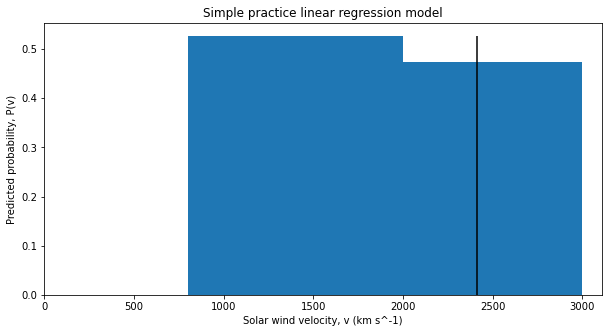

In [49]:
# Plotting 2 bin speed probability distribution histogram

fig = plt.figure(figsize = (10, 5))

v_bounds = [v_0, arb, max_v_2]
v_mids = [(arb + v_0)/2, (max_v_2 + arb)/2]
v_widths = [(arb - v_0), (max_v_2 - arb)]
probs = prac_model.predict_proba(prac_dp)[0]

ax1 = fig.add_subplot(1,1,1)
ax1.bar(v_mids, probs, width = v_widths)
ax1.vlines(prac_y_dp, 0, max(probs), color = 'black')
ax1.set_xlabel('Solar wind velocity, v (km s^-1)')
ax1.set_ylabel('Predicted probability, P(v)')
ax1.set_title('Simple practice linear regression model')
ax1.set_xlim(0)

In [52]:
# Calculating speed mode and bin width

prac_dp_pred_ind = np.where(probs == max(probs))[0][0]
prac_dp_pred = [v_mids[prac_dp_pred_ind], v_widths[prac_dp_pred_ind]/2]
print('v = (', prac_dp_pred[0], '\u00B1', prac_dp_pred[1], ') km ^-1')

v = ( 1400.0 ± 600.0 ) km ^-1


In [53]:
# Evaluating prediction

# Splitting data into training and test via single arbitrary value

slice_arb = int(pnt_num/2)
prac_X_tr = prac_X[:slice_arb]
prac_X_tst = prac_X[slice_arb:]
prac_y_arb_tr = prac_y_arb[:slice_arb]
prac_y_arb_tst = prac_y_arb[slice_arb:]


In [54]:
# Creating and fitting model from training data

prac_model_ev = LogisticRegression()
prac_model_ev.fit(prac_X_tr, prac_y_arb_tr)

LogisticRegression()

In [61]:
# Predicting from test data

prac_model_ev_pred = prac_model_ev.predict(prac_X_tst)
prac_model_ev_cm = confusion_matrix(prac_y_arb_tst, prac_model_ev_pred)
prac_model_ev_cm = [[' '                          , 'Actually over', 'Actually under'],
                    ['Predicted over' , prac_model_ev_cm[1][1]  , prac_model_ev_cm[0][1]],
                    ['Predicted under', prac_model_ev_cm[1][0]  , prac_model_ev_cm[0][0]]]
prac_model_ev_cm = pd.DataFrame(prac_model_ev_cm)
print(prac_model_ev_cm)

                 0              1               2
0                   Actually over  Actually under
1   Predicted over            142              46
2  Predicted under             77             235
